In [211]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import norm
from scipy.optimize import minimize

In [2]:
aapl_2016_2020_path = 'aapl_2016_2020.csv'
aapl_2021_2022_path = 'aapl_2021_2022.csv'

In [36]:
df1 = pd.read_csv(aapl_2016_2020_path, index_col=0, low_memory=False)
df2 = pd.read_csv(aapl_2021_2022_path, index_col=0, low_memory=False)

In [158]:
df2.columns

Index(['quote_readtime', 'quote_date', 'quote_time_hours', 'underlying_last',
       'expire_date', 'expire_unix', 'dte', 'c_delta', 'c_gamma', 'c_vega',
       'c_theta', 'c_rho', 'c_iv', 'c_volume', 'c_last', 'c_size', 'c_bid',
       'c_ask', 'strike', 'p_bid', 'p_ask', 'p_size', 'p_last', 'p_delta',
       'p_gamma', 'p_vega', 'p_theta', 'p_rho', 'p_iv', 'p_volume',
       'strike_distance', 'strike_distance_pct'],
      dtype='object')

In [44]:
df1.tail()[['underlying_last','dte', 'strike']]

,underlying_last,dte,strike
[QUOTE_UNIXTIME],,,
1490990400,143.67,658.04,185.0
1490990400,143.67,658.04,190.0
1490990400,143.67,658.04,195.0
1490990400,143.67,658.04,200.0
1490990400,143.67,658.04,210.0


In [37]:
df1.columns = [col.lower().replace('[', '').replace(']', '').strip() for col in df1.columns]
df2.columns = [col.lower().replace('[', '').replace(']', '').strip() for col in df2.columns]

In [187]:
df1[['p_rho', 'c_rho']]

,p_rho,c_rho
[QUOTE_UNIXTIME],,
1546462800,-0.000410,0.000740
1546462800,-0.000100,0.000000
1546462800,-0.000090,0.000000
1546462800,-0.000050,0.000000
1546462800,-0.000200,0.000000
...,...,...
1490990400,-2.973100,0.490070
1490990400,-3.177300,0.431340
1490990400,-3.368870,0.384330


In [240]:
_df1 = df1.set_index('quote_date')[['underlying_last', 'expire_date', 'strike', 'c_bid', 'c_ask', 'c_iv', 'c_last', 
                                    'p_bid', 'p_ask', 'p_iv', 'p_last']]
_df2 = df2.set_index('quote_date')[['underlying_last', 'expire_date', 'strike', 'c_bid', 'c_ask', 'c_iv', 'c_last', 
                                    'p_bid', 'p_ask', 'p_iv', 'p_last']]

In [241]:
df = pd.concat((_df1, _df2))
df

,underlying_last,expire_date,strike,c_bid,c_ask,c_iv,c_last,p_bid,p_ask,p_iv,p_last
quote_date,,,,,,,,,,,
2019-01-02,157.92,2019-01-04,100.0,57.700000,58.100000,3.253140,57.200000,0.000000,0.020000,1.625550,0.010000
2019-01-02,157.92,2019-01-04,105.0,52.500000,52.960000,,0.000000,0.000000,0.010000,1.461900,0.010000
2019-01-02,157.92,2019-01-04,110.0,47.450000,47.790000,,0.000000,0.000000,0.010000,1.305490,0.040000
2019-01-02,157.92,2019-01-04,115.0,40.700000,44.640000,,36.590000,0.000000,0.010000,1.155130,0.010000
2019-01-02,157.92,2019-01-04,120.0,35.710000,39.610000,,35.450000,0.000000,0.010000,1.010620,0.010000
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-30,138.09,2025-01-17,270.0,3.450000,4.100000,0.303290,4.400000,130.550000,132.900000,,112.200000
2022-09-30,138.09,2025-01-17,280.0,2.910000,3.650000,0.304060,4.310000,140.500000,142.900000,,122.000000
2022-09-30,138.09,2025-01-17,290.0,2.450000,3.150000,0.303170,3.750000,150.150000,152.950000,,132.240000


In [168]:
del _df1
del _df2

In [242]:
df['c_bid'] = df['c_bid'].map(lambda x: float(x) if x.strip() != '' else 0.0)
df['c_ask'] = df['c_ask'].map(lambda x: float(x) if x.strip() != '' else 0.0)
df['c_last'] = df['c_last'].map(lambda x: float(x) if x.strip() != '' else 0.0)
df['c_iv'] = df['c_iv'].map(lambda x: float(x) if x.strip() != '' else 0.0)
df['p_bid'] = df['p_bid'].map(lambda x: float(x) if x.strip() != '' else 0.0)
df['p_ask'] = df['p_ask'].map(lambda x: float(x) if x.strip() != '' else 0.0)
df['p_last'] = df['p_last'].map(lambda x: float(x) if x.strip() != '' else 0.0)
df['p_iv'] = df['p_iv'].map(lambda x: float(x) if x.strip() != '' else 0.0)

In [253]:
c_a = 0
c_b = 10
c_l = 11

(c_a + c_b + c_l) / ((1 if c_a else 0) + (1 if c_b else 0) + (1 if c_l else 0))

# _ddf.sum(axis=1), _ddf.astype(bool).sum(axis=1)

10.5

In [256]:
"""
calculates a market price of an option averaging none zero bid, ask and last prices
"""

df['p_mid'] = df[['p_bid', 'p_ask', 'p_last']].sum(axis=1) / df[['p_bid', 'p_ask', 'p_last']].astype(bool).sum(axis=1)
df['c_mid'] = df[['c_bid', 'c_ask', 'c_last']].sum(axis=1) / df[['c_bid', 'c_ask', 'c_last']].astype(bool).sum(axis=1)

In [257]:
df.describe()

,underlying_last,strike,c_bid,c_ask,c_iv,c_last,p_bid,p_ask,p_iv,p_last,p_mid,c_mid
count,1.491178e+06,1.491178e+06,1.491178e+06,1.491178e+06,1.491178e+06,1.491178e+06,1.491178e+06,1.491178e+06,1.491178e+06,1.491178e+06,1.487173e+06,1.487708e+06
mean,1.791166e+02,1.685185e+02,3.515400e+01,3.584403e+01,4.952775e-01,2.556333e+01,2.465008e+01,2.520385e+01,4.556792e-01,1.312793e+01,2.493578e+01,3.541933e+01
std,7.462933e+01,9.305551e+01,4.718221e+01,4.778293e+01,8.063271e-01,4.105360e+01,3.843709e+01,3.896355e+01,6.155762e-01,2.710697e+01,3.853635e+01,4.693251e+01
min,9.034000e+01,2.500000e+00,0.000000e+00,0.000000e+00,-5.000000e-04,0.000000e+00,0.000000e+00,0.000000e+00,-5.000000e-04,0.000000e+00,1.000000e-02,1.000000e-02
25%,1.326000e+02,1.050000e+02,1.100000e+00,1.230000e+00,2.656900e-01,4.000000e-02,3.000000e-01,3.800000e-01,2.399000e-01,1.000000e-02,3.566667e-01,1.213333e+00
50%,1.563400e+02,1.500000e+02,1.530000e+01,1.584000e+01,3.409200e-01,5.800000e+00,5.390000e+00,5.750000e+00,3.397400e-01,9.700000e-01,5.633333e+00,1.566667e+01
75%,1.942000e+02,2.150000e+02,5.345000e+01,5.455000e+01,4.873400e-01,3.543000e+01,3.425000e+01,3.520000e+01,4.965900e-01,1.210000e+01,3.485333e+01,5.413667e+01
max,5.061900e+02,1.000000e+03,4.291000e+02,4.333900e+02,6.426971e+01,4.135000e+02,5.190000e+02,5.229900e+02,3.549892e+01,5.216500e+02,5.212133e+02,4.148733e+02


In [258]:
df['expire_date'] = df['expire_date'].map(lambda x: pd.to_datetime(x))

In [259]:
df.index = df.index.map(lambda x: pd.to_datetime(x))
df

,underlying_last,expire_date,strike,c_bid,c_ask,c_iv,c_last,p_bid,p_ask,p_iv,p_last,p_mid,c_mid
quote_date,,,,,,,,,,,,,
2019-01-02,157.92,2019-01-04,100.0,57.70,58.10,3.25314,57.20,0.00,0.02,1.62555,0.01,0.015000,57.666667
2019-01-02,157.92,2019-01-04,105.0,52.50,52.96,0.00000,0.00,0.00,0.01,1.46190,0.01,0.010000,52.730000
2019-01-02,157.92,2019-01-04,110.0,47.45,47.79,0.00000,0.00,0.00,0.01,1.30549,0.04,0.025000,47.620000
2019-01-02,157.92,2019-01-04,115.0,40.70,44.64,0.00000,36.59,0.00,0.01,1.15513,0.01,0.010000,40.643333
2019-01-02,157.92,2019-01-04,120.0,35.71,39.61,0.00000,35.45,0.00,0.01,1.01062,0.01,0.010000,36.923333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-30,138.09,2025-01-17,270.0,3.45,4.10,0.30329,4.40,130.55,132.90,0.00000,112.20,125.216667,3.983333
2022-09-30,138.09,2025-01-17,280.0,2.91,3.65,0.30406,4.31,140.50,142.90,0.00000,122.00,135.133333,3.623333
2022-09-30,138.09,2025-01-17,290.0,2.45,3.15,0.30317,3.75,150.15,152.95,0.00000,132.24,145.113333,3.116667


---
# Task1

Найти локальную волатильность $\sigma_{loc}(K, T)$. Построить график $\sigma_{loc}(K, T)$ как функцию двух переменных.

$\sigma^2(K, T, S_0) = \frac{\frac{\partial C}{\partial T}}{\frac{1}{2}K^2\frac{\partial^2 C}{\partial K^2}}$

Given a complete set of European prices for all strikes and expirations, local volatilities are given uniquely by equation

In [260]:
len(df['strike'].unique())

491

In [261]:
daily_data = []
for i in df.resample('1d'):
    # daily_data.append(pd.DataFrame(i[-1]))
    daily_data.append(i[-1])
daily_data[0]

,underlying_last,expire_date,strike,c_bid,c_ask,c_iv,c_last,p_bid,p_ask,p_iv,p_last,p_mid,c_mid
quote_date,,,,,,,,,,,,,
2016-01-04,105.35,2016-01-08,60.0,45.19,45.51,0.00030,0.00,0.00,0.02,1.68940,0.00,0.020000,45.350000
2016-01-04,105.35,2016-01-08,65.0,40.20,40.51,-0.00042,0.00,0.00,0.02,1.46326,0.00,0.020000,40.355000
2016-01-04,105.35,2016-01-08,70.0,35.20,35.49,-0.00010,0.00,0.00,0.03,1.25453,0.00,0.030000,35.345000
2016-01-04,105.35,2016-01-08,75.0,30.20,30.51,-0.00035,0.00,0.00,0.02,1.05894,0.00,0.020000,30.355000
2016-01-04,105.35,2016-01-08,80.0,25.19,25.51,0.00013,0.00,0.00,0.01,0.81605,0.01,0.010000,25.350000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-01-04,105.35,2018-01-19,160.0,2.88,3.30,0.26537,3.20,56.91,58.60,0.22759,0.00,57.755000,3.126667
2016-01-04,105.35,2018-01-19,165.0,2.25,2.84,0.26192,2.69,60.90,63.11,0.20975,0.00,62.005000,2.593333
2016-01-04,105.35,2018-01-19,170.0,2.30,2.46,0.26746,2.35,65.51,66.75,0.15929,66.40,66.220000,2.370000


In [262]:
_df = daily_data[0]

In [264]:
strikes = _df['strike'].unique()

In [265]:
strike = strikes[0]

In [295]:
_df_strike = _df[_df['strike'] == strike].sort_values(by='expire_date')

c_diff = (_df_strike['c_mid'] - _df_strike['c_mid'].shift()).dropna()
t_diff = (_df_strike['expire_date'] - _df_strike['expire_date'].shift()).dropna().map(lambda x: int(x.days))

c_d = c_diff / t_diff

quote_dates = _df['expire_date'].unique()

date = quote_dates[0]

_df_quote = _df[_df['expire_date'] == date].sort_values(by='strike').dropna()

k_diff = (_df_quote['strike'] - _df_quote['strike'].shift()).dropna()
c_diff = (_df_quote['c_mid'] - _df_quote['c_mid'].shift()).dropna()

c_s_diff = ((c_diff - c_diff.shift()).dropna() / k_diff.shift().dropna())

---
Task3

Нарисуйте двумерные графики подразумеваемой волатильности $\sigma(K, T)$ по датасету цен опционов на AAPL 
(отдельно на колл и пут опционов) при фиксированном T = T_0 нарисуйте в одном окне два графика 
(для колл и пут опционов) подразумеваемой волатильности  $\sigma(K, T)$ как функцию от К

In [172]:
df

,underlying_last,expire_date,strike,c_bid,c_ask,c_iv,p_bid,p_ask,p_iv,p_mid,c_mid
quote_date,,,,,,,,,,,
2019-01-02,157.92,2019-01-04,100.0,57.70,58.10,3.25314,0.00,0.02,1.62555,0.010,57.900
2019-01-02,157.92,2019-01-04,105.0,52.50,52.96,0.00000,0.00,0.01,1.46190,0.005,52.730
2019-01-02,157.92,2019-01-04,110.0,47.45,47.79,0.00000,0.00,0.01,1.30549,0.005,47.620
2019-01-02,157.92,2019-01-04,115.0,40.70,44.64,0.00000,0.00,0.01,1.15513,0.005,42.670
2019-01-02,157.92,2019-01-04,120.0,35.71,39.61,0.00000,0.00,0.01,1.01062,0.005,37.660
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-30,138.09,2025-01-17,270.0,3.45,4.10,0.30329,130.55,132.90,0.00000,131.725,3.775
2022-09-30,138.09,2025-01-17,280.0,2.91,3.65,0.30406,140.50,142.90,0.00000,141.700,3.280
2022-09-30,138.09,2025-01-17,290.0,2.45,3.15,0.30317,150.15,152.95,0.00000,151.550,2.800


In [175]:
unique_strikes = df['strike'].unique()

In [185]:
T = (df.reset_index().iloc[0]['expire_date'] - df.reset_index().iloc[0]['quote_date']).days

In [186]:
T

2

In [200]:
def calc_Black_Scholes_equation(S0, T, K, sigma, r=0.03):
    alpha_pl = (np.log(S0 / K) + (r + sigma**2 / 2) * T) / np.sqrt(T) / sigma
    alpha_ms = (np.log(S0 / K) + (r - sigma**2 / 2) * T) / np.sqrt(T) / sigma

    return S0 * norm.cdf(alpha_pl) - K * np.exp(-r * T)*norm.cdf(alpha_ms)

def optim_Black_Scholes_equation(S0, T, K, price, sigma):
    
    return np.abs(calc_Black_Scholes_equation(S0, T, K, sigma) - price)

In [201]:
calc_Black_Scholes_equation(150, 1, 155, 0.1)

5.782797357585267

In [207]:
x0 = 0.1
S0 = df.reset_index().iloc[0]['underlying_last']
T = T = (df.reset_index().iloc[0]['expire_date'] - df.reset_index().iloc[0]['quote_date']).days
K = df.reset_index().iloc[0]['strike']
price = df.iloc[0]['c_mid']

res = minimize(lambda x: optim_Black_Scholes_equation(S0=S0, T=T, K=K, price=price, sigma=x), x0, method='Nelder-Mead', tol=1e-6)
res.x[0] * 100

3.0000000000000138

In [208]:
df.reset_index().iloc[0]['c_iv']

3.25314

In [217]:
df

,underlying_last,expire_date,strike,c_bid,c_ask,c_iv,p_bid,p_ask,p_iv,p_mid,c_mid
quote_date,,,,,,,,,,,
2019-01-02,157.92,2019-01-04,100.0,57.70,58.10,3.25314,0.00,0.02,1.62555,0.010,57.900
2019-01-02,157.92,2019-01-04,105.0,52.50,52.96,0.00000,0.00,0.01,1.46190,0.005,52.730
2019-01-02,157.92,2019-01-04,110.0,47.45,47.79,0.00000,0.00,0.01,1.30549,0.005,47.620
2019-01-02,157.92,2019-01-04,115.0,40.70,44.64,0.00000,0.00,0.01,1.15513,0.005,42.670
2019-01-02,157.92,2019-01-04,120.0,35.71,39.61,0.00000,0.00,0.01,1.01062,0.005,37.660
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-30,138.09,2025-01-17,270.0,3.45,4.10,0.30329,130.55,132.90,0.00000,131.725,3.775
2022-09-30,138.09,2025-01-17,280.0,2.91,3.65,0.30406,140.50,142.90,0.00000,141.700,3.280
2022-09-30,138.09,2025-01-17,290.0,2.45,3.15,0.30317,150.15,152.95,0.00000,151.550,2.800


In [231]:
sub_df = df.iloc[np.arange(0, len(df), 1)[(df.reset_index()['expire_date'] - df.reset_index()['quote_date']).map(lambda x: x.days).values == 60]]

In [232]:
sub_df

,underlying_last,expire_date,strike,c_bid,c_ask,c_iv,p_bid,p_ask,p_iv,p_mid,c_mid
quote_date,,,,,,,,,,,
2019-01-14,150.00,2019-03-15,75.0,74.84,75.34,1.26833,0.02,0.04,0.61561,0.030,75.090
2019-01-14,150.00,2019-03-15,80.0,69.80,70.30,1.10803,0.03,0.04,0.58148,0.035,70.050
2019-01-14,150.00,2019-03-15,85.0,64.90,65.34,0.98414,0.05,0.05,0.55625,0.050,65.120
2019-01-14,150.00,2019-03-15,90.0,59.90,60.35,0.86452,0.08,0.11,0.53642,0.095,60.125
2019-01-14,150.00,2019-03-15,95.0,54.75,55.34,0.74582,0.12,0.14,0.50667,0.130,55.045
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-19,154.53,2022-11-18,260.0,0.01,0.01,0.41191,105.40,105.65,0.87123,105.525,0.010
2022-09-19,154.53,2022-11-18,270.0,0.01,0.01,0.43900,115.40,115.65,0.95014,115.525,0.010
2022-09-19,154.53,2022-11-18,280.0,0.01,0.01,0.46413,125.35,125.75,1.03162,125.550,0.010


In [330]:
iv_empiric = []
real_v = []
Ks = []

# fix quote date instead 

quote_date = _df.reset_index()['quote_date'].unique()[0]

sub_df = _df.loc[quote_date].sort_values(by='strike')

for i in tqdm(range(len(sub_df))):

    if sub_df.iloc[i]['c_iv'] != 0 and sub_df.iloc[i]['underlying_last'] and sub_df.iloc[i]['c_mid']:
        x0 = 0.1
        S0 = sub_df.iloc[i]['underlying_last']
        K = sub_df.iloc[i]['strike']
        T = (sub_df.reset_index().iloc[0]['expire_date'] - sub_df.reset_index().iloc[0]['quote_date']).days
        price = sub_df.iloc[i]['c_mid']
        
        res = minimize(lambda x: optim_Black_Scholes_equation(S0=S0, T=T, K=K, price=price, sigma=x), x0, method='Nelder-Mead', tol=1e-6)
        
        iv_empiric.append(res.x[0] * 100)
        real_v.append(sub_df.iloc[i]['c_iv'])
        Ks.append(K)
    else:
        continue

100%|█████████████████████████████████████████████████████████████████████████████████| 571/571 [00:02<00:00, 285.33it/s]


In [333]:
# sub_df.sort_values(by='strike')
sub_df[sub_df['strike'] == 40]

,underlying_last,expire_date,strike,c_bid,c_ask,c_iv,c_last,p_bid,p_ask,p_iv,p_last,p_mid,c_mid
quote_date,,,,,,,,,,,,,
2016-01-04,105.35,2016-01-15,40.0,65.2,65.51,0.00008,0.0,0.0,0.02,1.81934,0.0,0.02,65.355


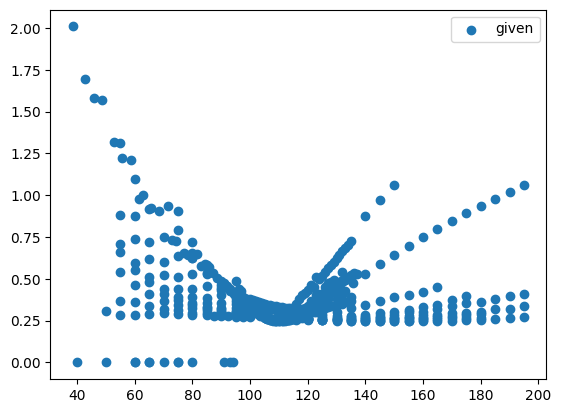

In [332]:
# plt.scatter(np.sort(Ks), np.array(iv_empiric)[np.argsort(Ks)], label='calculated')
plt.scatter(np.sort(Ks), np.array(real_v)[np.argsort(Ks)], label='given')

plt.legend()
plt.show()

---
# Task4

Найдите цену европейского колл опциона в модели Хестона с помощью Монте Карло, используя дискретизации 
Эйлера и Мильштейна и оценив дисперсии получаемых ответов (т.е. для каждой дискретизации запустить 100 блоков 
по 1000 траекторий и в каждом блоке подсчитать ответ)